In [1]:
# Baked-in within python modules
from collections import defaultdict

# Python plotting library
import matplotlib as mpl
import matplotlib.pyplot as plt

# Numerical python library (pronounced "num-pie")
import numpy as np

# Dataframes in Python
import pandas as pd

# T-test of independent samples
from scipy.stats import ttest_ind

# Statistical plotting library we'll use
import seaborn as sns
sns.set(style='whitegrid')

import statsmodels.formula.api as sm

# Matrix decomposition
from sklearn.decomposition import PCA, FastICA

# Manifold learning
from sklearn.manifold import MDS, TSNE

# Clustering
from sklearn.cluster import KMeans, MiniBatchKMeans

# Plotting dendrograms
from scipy.cluster import hierarchy

from time import time
import multiprocessing as mp

from scipy.stats import mannwhitneyu

import hdbscan

%matplotlib inline

In [2]:
dataSets = ['/home/dnunez/DATA2/56_erm/dgeOneEditMerged.txt.gz']
labels = [d[19:21] for d in dataSets]
_ = [print(d) for d in dataSets]
print(labels)

/home/dnunez/DATA2/56_erm/dgeOneEditMerged.txt.gz
['56']


In [3]:
#LOAD DGE
totCells = 0
toMerge = []
for i in range(0,len(dataSets)):
    dge = pd.read_csv(dataSets[i], sep='\t', index_col=0, float_precision='high')
    dge = dge.transpose()
    print(dge.shape)
    totCells += dge.shape[0]
    dge = dge.rename(columns={np.nan : "nan"})
    temp = {}
    for ind in dge.index:
        temp[ind] = ind + '.' + str(i)
    toMerge.append(dge.rename(index=temp))

dge = pd.concat(toMerge)
print(dge.shape)
print(totCells)
dge = dge.fillna(value=0)

(1536, 12568)
(1536, 12568)
1536


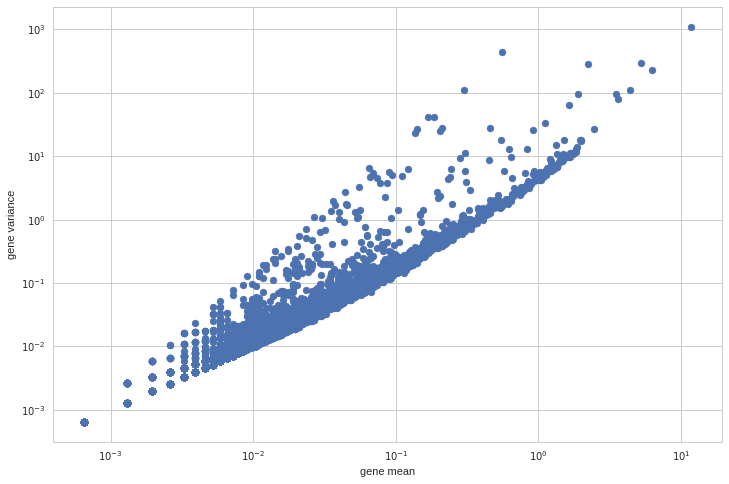

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(dge.mean(),dge.var())
ax.set_xlabel('gene mean')
ax.set_ylabel('gene variance')

In [5]:
transcriptNum = dge.sum(axis=1)
geneNum = dge.astype(bool).sum(axis=1)

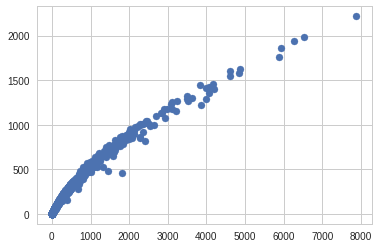

In [6]:
plt.scatter(transcriptNum,geneNum)

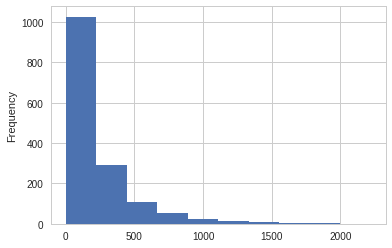

In [7]:
geneNum.plot.hist()

In [8]:
#FILTER DGE
cells2Keep = dge.astype(bool).sum(axis=1)
dge = dge.loc[cells2Keep > 800, :]
#dge = dge.loc[transcriptNum > 500, :]
genes2Keep = dge.astype(bool).sum()
dge = dge.loc[:, genes2Keep >= 3]
dgeBool = dge.astype(bool)
print(dge.shape)

(75, 5612)


In [9]:
mitoGenes = [s for s in dge.keys() if "mt:" in s]
percentMito = dge[mitoGenes].sum(axis=1)/dge.sum(axis=1)

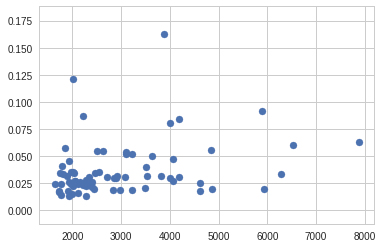

In [10]:
plt.scatter(transcriptNum[percentMito.index],percentMito)

In [25]:
dge = dge[percentMito < 0.75]
print(dge.shape)

(75, 5612)


In [9]:
def findHVG(dge):

    xlow = 0.0125
    xhigh = 3.0
    ylow = 0.5
    
    #GET HIGHLY VARIABLE GENES
    #note that this is done on un-regressed data in Seurat
    expMean = np.log(np.mean(np.exp(dge)-1)+1)
    logVarDivMean = np.log(np.var(np.exp(dge)-1,ddof=1)/np.mean(np.exp(dge)-1))
    binedExpMean, bins = pd.cut(expMean,20,labels=range(0,20),retbins=True)
    meanLogVarDivMean = [logVarDivMean[binedExpMean == i].mean() for i in range(0,20)]
    stdLogVarDivMean = [logVarDivMean[binedExpMean == i].std() for i in range(0,20)]
    normalizedDispersion = [(logVarDivMean[i] - meanLogVarDivMean[binedExpMean[i]])/\
                           stdLogVarDivMean[binedExpMean[i]] for i in range(0,len(logVarDivMean))]
    normalizedDispersion = pd.Series(normalizedDispersion,index=expMean.index)
    normalizedDispersion = normalizedDispersion.fillna(value=0)
    varGenes = expMean[(normalizedDispersion > ylow) & (expMean > xlow) & (expMean < xhigh)].index.tolist()
    
    #DISPERSION V MEAN EXPRESSION
    fig, ax = plt.subplots(figsize=(12, 8))
    # Plot the first ("0") and second ("1") components
    ax.scatter(expMean,normalizedDispersion, s=30, c='k',edgecolor='white', linewidth=1,alpha=0.3)
    ax.scatter(expMean[(normalizedDispersion > ylow) & (expMean > xlow) & (expMean < xhigh)]\
               ,normalizedDispersion[(normalizedDispersion > ylow) & (expMean > xlow) & (expMean < xhigh)]\
               , s=30, c = 'r', edgecolor='white', linewidth=1,alpha=0.3)
    xlabel = 'mean expression for each gene'
    ylabel = 'dispersion'
    ax.set_xlabel(xlabel,fontsize=20)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    return varGenes

def regressDGE(dge):
    
    mitoGenes = [s for s in dge.keys() if "mt:" in s]
    percentMito = dge[mitoGenes].sum(axis=1)/dge.sum(axis=1)
    batch = [ind[13] for ind in dge.index]
    transcriptNum = dge.sum(axis=1)
    
    #REGRESS OUT UMI, mito, batch
    #"Gene ~ pMito + UMIs + C(Batch)"
    newDGE=[]
    for x in dge.columns.values:
        newPanda = pd.DataFrame({"Gene":dge[x].tolist(),"UMIs":transcriptNum,"pMito":percentMito, "Batch":batch})
        #"Gene ~ pMito + UMIs + C(Batch)"
        result = sm.ols(formula="Gene ~ pMito + UMIs + C(Batch)", data=newPanda).fit()
        newDGE.append(result.resid.rename(x))
    
    return pd.concat(newDGE,axis=1)

def regressOutLatentVars(dge):
    
    n_threads=23
    geneList = dge.columns.values
    chunk_size = int(len(geneList)/n_threads)
    n_chunks = int(len(geneList)/chunk_size)
    dataChunks = []
    for i in range(0, n_chunks):
        if (i < n_chunks - 1):
            dataChunks.append(dge[geneList[i*chunk_size:(i+1)*chunk_size]])
        else:
            dataChunks.append(dge[geneList[i*chunk_size:]])
    del dge

    # create the multiprocessing worker pool
    workers = mp.Pool(processes = n_threads)
    multi_threaded_result = []
    for result in workers.imap_unordered(regressDGE, dataChunks, chunksize=1):
        multi_threaded_result.append(result)
    workers.close()
    workers.join()
    del dataChunks
    
    newDGE = pd.concat(multi_threaded_result,axis=1) 
    del multi_threaded_result
    
    #Z-SCORE DATA
    scaledDge = (newDGE - newDGE.mean())/newDGE.std()
    
    return newDGE, scaledDge


In [10]:
 #LOG NORMALIZE DGE
dge = np.log(dge.div(dge.sum(axis=1), axis=0)*1e4+1)

proportion mitochondrial: 0.00847457627118644
proportion ribosomal protein: 0.005932203389830509
proportion non-protein coding: 0.03220338983050847
proportion rRNA: 0.006779661016949152
proportion tRNA: 0.0
proportion snRNA: 0.000847457627118644
proportion snoRNA: 0.020338983050847456
proportion miRNA: 0.000847457627118644
proportion lncRNA: 0.0
proportion asRNA: 0.0
proportion pseudo: 0.0


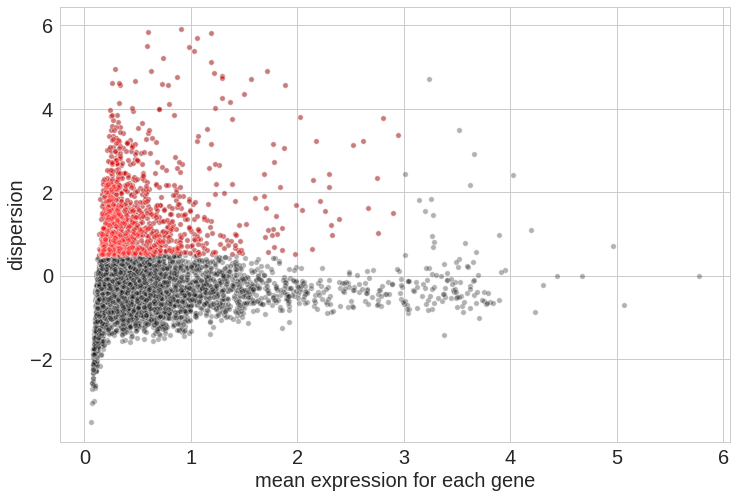

In [40]:
#varGenes = dge.var().sort_values(ascending=False).iloc[0:1000].index
varGenes = findHVG(dge)
print('proportion mitochondrial: ' + str(len([s for s in varGenes if "mt:" in s[0:3]])/len(varGenes)))
print('proportion ribosomal protein: ' + str(len([s for s in varGenes if "Rp" in s[0:2]])/len(varGenes)))
print('proportion non-protein coding: ' + str(len([s for s in varGenes if "CR" in s[0:2]])/len(varGenes)))
print('proportion rRNA: ' + str(len([s for s in varGenes if "SrRNA" in s[1:7]])/len(varGenes)))
print('proportion tRNA: ' + str(len([s for s in varGenes if "tRNA:" in s[0:5]])/len(varGenes)))
print('proportion snRNA: ' + str(len([s for s in varGenes if "snRNA:" in s[0:6]])/len(varGenes)))
print('proportion snoRNA: ' + str(len([s for s in varGenes if "snoRNA:" in s[0:7]])/len(varGenes)))
print('proportion miRNA: ' + str(len([s for s in varGenes if "mir-" in s[0:4]])/len(varGenes)))
print('proportion lncRNA: ' + str(len([s for s in varGenes if "lncRNA:" in s[0:6]])/len(varGenes)))
print('proportion asRNA: ' + str(len([s for s in varGenes if "asRNA:" in s[0:5]])/len(varGenes)))
print('proportion pseudo: ' + str(len([s for s in varGenes if "-ps" in s])/len(varGenes)))

In [12]:
dge, scaledDge = regressOutLatentVars(dge)

In [16]:
scaledDge['14-3-3epsilon']

ACACTTAAAAGC.0    0.182131
TTCTGTCGGAGC.0    0.424673
TTGCTTTTTTAT.0    0.708407
TTTGCACACCTG.0   -0.182498
GAAGCCACTTTN.0    1.757641
GACCTAAACTGN.0    2.175668
GAGACGTTTCCN.0    0.355414
GGGCCGTAAACA.0   -1.167230
GGGGCCGATACA.0    0.254816
GATAACTACTCN.0    0.008450
GGTGATCCGTCN.0    1.446652
GTAAGGAGCAGA.0    0.448955
GTCGAGTACAGN.0   -1.838384
GTGAGGCACGGT.0   -0.486103
GTGATCCTTATG.0   -1.244182
TAGAGCCCGTTA.0   -0.103289
TAGTTCCAGCAG.0   -1.072973
TGAGTTGCGTAA.0    0.189499
CGCCGACTCGAG.0   -0.388198
CATAGAGTTAGG.0    0.041025
CGTTGCACTTAG.0    0.233232
CCCACACGACCN.0    0.041746
CCCTATTACTTG.0   -0.264445
CCGGTATGGTGN.0    0.168024
GATATGACCATG.0    1.232302
GATGCGGGTCCA.0   -0.025413
GCGAGATACCGN.0    1.453804
GCGGGATTACCC.0    0.885620
GCGTTACCTCCT.0    0.218947
GCTAGAGGCAAG.0   -0.480054
                    ...   
AATCGGTTGAAN.0   -1.741047
ACCACCTTGACA.0    0.568934
TCAGCCCCGTCC.0    1.031770
TCACCGGTCCCA.0   -0.629321
TCACTTTGGTTC.0    0.642508
TCAGTTGATAAG.0   -1.683967
T

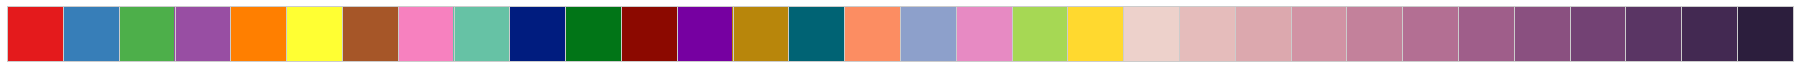

In [31]:
colors = sns.color_palette("Set1", 8) \
+ sns.color_palette("Set2",1) \
+ sns.color_palette("dark",1) \
+ sns.color_palette("dark",6)[1:] \
+ sns.color_palette("Set2",6)[1:] \
+ sns.cubehelix_palette(12)
# colors = [sns.color_palette("nipy_spectral",11,desat=0.75)[i] for i in\
#           np.random.choice(range(0,11),11,replace=False)]
#colors = sns.color_palette("husl",12)
#colors.pop(0)
sns.palplot(colors)

In [32]:
def findClusters(dge,varGenes,perplexity,min_cluster_size):
    
    #PCA
    smusher = PCA(n_components=5)
    smushed = pd.DataFrame(smusher.fit_transform(dge[varGenes]), 
                                      index=dge.index)
    print(smushed.shape)
    PC1 = 1
    PC2 = 2
    fig, ax = plt.subplots(figsize=(12, 8))
    # Plot the first ("0") and second ("1") components
    ax.scatter(smushed[PC1 - 1], smushed[PC2 - 1], \
               s=transcriptNum.loc[smushed.index]/10, edgecolor='white', linewidth=1, \
               c=[colors[int(smushed.index[i][13])] for i in range(0,len(smushed.index))])
    xlabel = 'PC' + str(PC1) + ' explains {:.1f}% variance'.format(100*smusher.explained_variance_ratio_[PC1 - 1])
    ylabel = 'PC' + str(PC2) + ' explains {:.1f}% variance'.format(100*smusher.explained_variance_ratio_[PC2 - 1])
    ax.set_xlabel(xlabel,fontsize=20)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    #TSNE
    tsne_smusher = TSNE(n_components=2, random_state=245, perplexity=perplexity, method='barnes_hut', angle=0.5, \
                   learning_rate=200, early_exaggeration=12.0)
    tsne_smushed = pd.DataFrame(tsne_smusher.fit_transform(smushed), index=dge.index)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(tsne_smushed[0], tsne_smushed[1], s=transcriptNum.loc[smushed.index]/10, \
               edgecolor='white', linewidth=1)
    ax.set_xlabel('tSNE1')
    ax.set_ylabel('tSNE2')
    
    #Cluster
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, gen_min_span_tree=True)
    clusterer.fit(tsne_smushed.as_matrix())
    
    #plot clusters
    fig, ax = plt.subplots(figsize=(8,8))
    cluster_colors = [colors[col]
                      if col >= 0 else (0.5, 0.5, 0.5) for col in clusterer.labels_]
    ax.scatter(tsne_smushed[0], tsne_smushed[1], c=cluster_colors, \
               edgecolor='white', linewidth=1)
    ax.set_xlabel('tSNE 1')
    ax.set_ylabel('tSNE 2')
    
    return tsne_smushed, clusterer

In [33]:
tsne_smushed, clusterer = findClusters(scaledDge,varGenes,perplexity=40,min_cluster_size=10)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#FEATURE PLOTS (TRANSCRIPT NUM)
fig, ax = plt.subplots(figsize=(12,8))
temp = ax.scatter(tsne_smushed[0], tsne_smushed[1],s=60, edgecolor='white', linewidth=1, \
           cmap='coolwarm',c=np.log10(transcriptNum.loc[dge.index]))
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')
cb = plt.colorbar(temp)
#cb.set_ticks([0,1,2])
cb.set_label('log # of transcripts')

In [ ]:
genes=['dpn','ase','klu','pros','D','grh','ey','toy','elav','bsh','repo','nSyb']
#plot genes of interest
fig, ax = plt.subplots(3,4, figsize=(12,8))
for i in range(0,4):
    scat = ax[0,i].scatter(tsne_smushed[0], tsne_smushed[1],s=60, edgecolor='black', linewidth=1, 
               cmap='Reds',c=dge[genes[i]])
    cb = plt.colorbar(scat, ax=ax[0,i])
    cb.set_label('log(CP10K+1)',fontsize=16)
    ax[0,i].set_title(genes[i],fontsize=20)
    ax[0,i].grid(False)
    ax[0,i].set_axis_off()
for i in range(0,4):
    scat = ax[1,i].scatter(tsne_smushed[0], tsne_smushed[1],s=60, edgecolor='black', linewidth=1, 
               cmap='Reds',c=dge[genes[4+i]])
    cb = plt.colorbar(scat,ax=ax[1,i])
    cb.set_label('log(CP10K+1)',fontsize=16)
    ax[1,i].set_title(genes[4+i],fontsize=20)
    ax[1,i].grid(False)
    ax[1,i].set_axis_off()
for i in range(0,4):
    scat = ax[2,i].scatter(tsne_smushed[0], tsne_smushed[1],s=60, edgecolor='black', linewidth=1, 
               cmap='Reds',c=dge[genes[8+i]])
    cb = plt.colorbar(scat,ax=ax[2,i])
    cb.set_label('log(CP10K+1)',fontsize=16)
    ax[2,i].set_title(genes[8+i],fontsize=20)
    ax[2,i].grid(False)
    ax[2,i].set_axis_off()
fig.tight_layout()
#plt.savefig('tSNE_geneHeat_Smooth_3000g_40perp.jpg',format = 'jpg',dpi = 400)

In [19]:
#if doing with smoothDGE, should load original DGE!!!

#find differentially expressed genes
differentiatingGenes = []
for i in range(0,max(clusterer.labels_)+1):
    
    #logFC
    meanGroup1 = np.log((np.exp(dge[clusterer.labels_ == i])-1).mean()+1)
    meanGroup2 = np.log((np.exp(dge[clusterer.labels_ != i])-1).mean()+1)
    logFC = meanGroup1 - meanGroup2
    pctIn = dgeBool.loc[dge.index][clusterer.labels_ == i].sum()/dge[clusterer.labels_ == i].shape[0]
    pctOut = dgeBool.loc[dge.index][clusterer.labels_ != i].sum()/dge[clusterer.labels_ != i].shape[0]
    pctDiff = pctIn - pctOut
    #join them
    diffExp = pd.concat([logFC,pctIn,pctOut,pctDiff], axis=1)
    diffExp.columns = ['logFC','pctIn','pctOut','pctDiff']
    genes2use = diffExp[(abs(diffExp.logFC) > 0.25) & (abs(diffExp.pctDiff) > 0.15)].index
    diffExp = diffExp.loc[genes2use]
    
    pvalues = []
    for g in genes2use:
        statistic, pval = mannwhitneyu(dge[clusterer.labels_ == i][g].tolist(),\
            dge[clusterer.labels_ != i][g].tolist(),\
                 use_continuity = True, alternative = 'two-sided')
        pvalues.append(pval)
    diffExp['pval'] = pd.Series(pvalues, index=genes2use)
    diffExp['cluster'] = [i for g in genes2use]
    differentiatingGenes.append(diffExp)
differentiatingGenes = pd.concat(differentiatingGenes)

In [29]:
#differentiatingGenes[differentiatingGenes.pval<1e-3].to_csv('/home/dnunez/DATA2/68_erm/diffExpressedGenes.csv')

In [48]:
cluster=3
# differentiatingGenes[(differentiatingGenes.cluster==cluster) & \
#                     (differentiatingGenes.pval<0.05/dge.shape[1])].sort_values('pval').to_csv(\
#                         'cluster' + str(cluster) + 'genes.csv' )

differentiatingGenes[(differentiatingGenes.cluster==cluster) & \
                    (differentiatingGenes.pval<0.05/dge.shape[1])].sort_values('logFC',ascending=False)

,logFC,pctIn,pctOut,pctDiff,pval,cluster
CG13741,1.447900,0.746479,0.000000,0.746479,1.444910e-32,3
CG7372,1.194462,1.000000,0.782313,0.217687,3.149287e-34,3
Hrb87F,1.066084,1.000000,0.530612,0.469388,8.929400e-34,3
l(1)G0289,0.936378,0.802817,0.959184,-0.156367,1.914786e-12,3
kay,0.638985,1.000000,0.530612,0.469388,4.664267e-23,3
Ssrp,0.610671,1.000000,0.741497,0.258503,1.286003e-31,3
ctrip,0.595434,0.985915,0.795918,0.189997,3.587078e-23,3
ATPsyn-gamma,0.586414,1.000000,0.761905,0.238095,1.695553e-31,3
skl,0.559135,1.000000,0.741497,0.258503,1.099550e-24,3
Tim17b,0.485785,0.985915,0.795918,0.189997,2.452600e-28,3


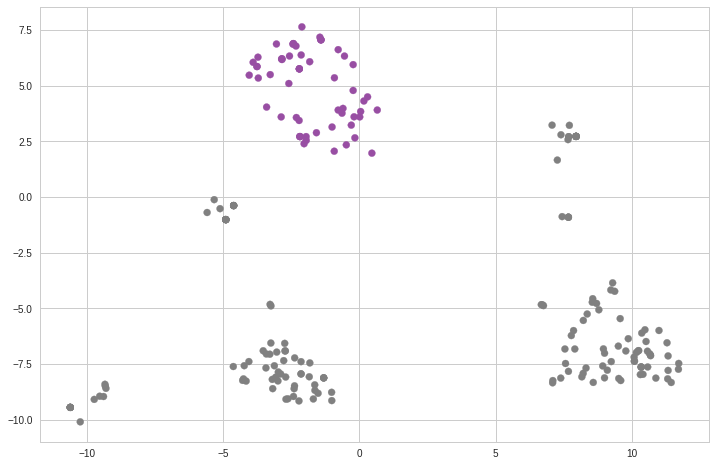

In [49]:
#highlight cluster on tSNE
fig, ax = plt.subplots(figsize=(12,8))
cluster_colors = [colors[col]
                  if col == cluster else (0.5, 0.5, 0.5) for col in clusterer.labels_]
ax.scatter(tsne_smushed[0], tsne_smushed[1], c=cluster_colors)

In [27]:
'bsh' in differentiatingGenes.index

True

In [46]:
exclude = [s for s in differentiatingGenes.index if "snoRNA:" in s[0:7]] +\
[s for s in differentiatingGenes.index if "CG" in s[0:2]]+\
[s for s in differentiatingGenes.index if "CR" in s[0:2]]+\
[s for s in differentiatingGenes.index if "mt:" in s[0:3]]+\
['Cpr11B','dpr20','grk','alphagamma-element:CR32865']
include = list(set(differentiatingGenes.index)-set(exclude))

In [47]:
top10Genes = []
for i in range(0,max(clusterer.labels_)+1):
    top10Genes += differentiatingGenes[differentiatingGenes.cluster==i].loc[include].sort_values('pval').index[0:10].tolist()

In [48]:
order = []
for i in range(0,max(clusterer.labels_)+1):
    order += dge.index[clusterer.labels_== i].tolist()

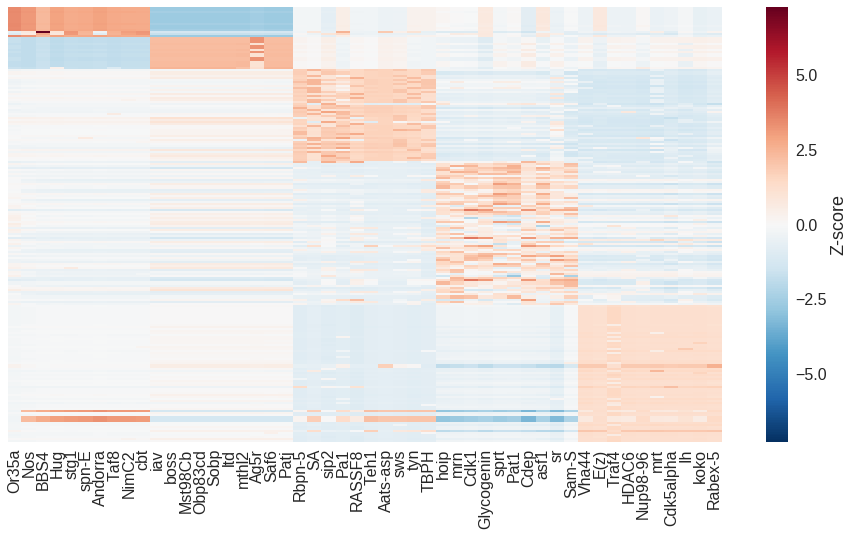

In [49]:
fig,ax = plt.subplots(figsize=[16,8])
#plt.tight_layout()
sns.heatmap(scaledDge.loc[order][top10Genes], yticklabels=False, cbar_kws=dict(label='Z-score'))
plt.savefig('geneHeat_Smooth_3000g_40perp.jpg',format = 'jpg',dpi = 400, bbox_inches = "tight")

/home/dnunez/DATA/Py3Env2/Py3Env2/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


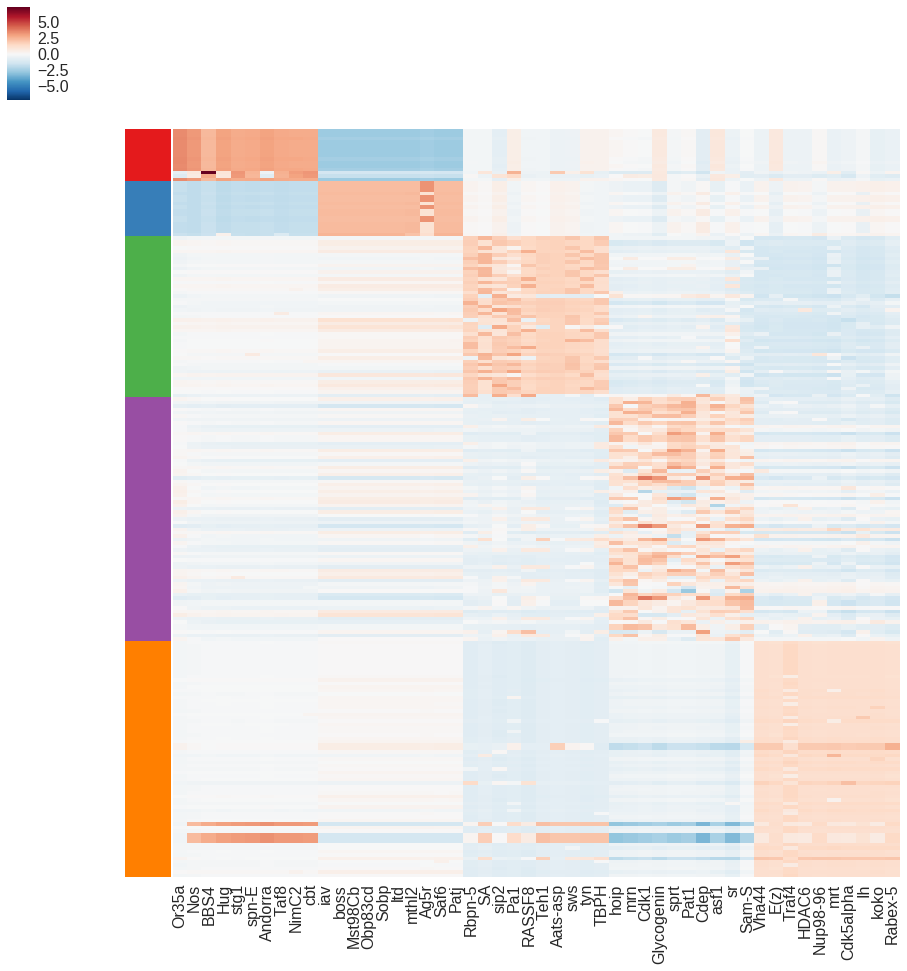

In [50]:
cluster_colors = [colors[col]
                  if col >= 0 else (0.5, 0.5, 0.5) for col in clusterer.labels_]
cluster_colors = pd.Series(cluster_colors,index=dge.index)
#sns.heatmap(scaledDge.loc[order][top10Genes], yticklabels=False, row_colors=cluster_colors)
sns.clustermap(scaledDge.loc[order][top10Genes], yticklabels=False,\
               row_colors=cluster_colors.loc[order].tolist(),\
               row_cluster=False, col_cluster=False,\
              figsize=[16,16])
plt.savefig('geneHeat_Smooth_3000g_40perp_colorbar.jpg',format = 'jpg',dpi = 400)

In [33]:
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [20]:
#'klu','elav','ey','ckn','Rcc1','klu','D','VGlut','Wnk','elav','nSyb','Syx5','bsh','Mp','grh','dpn','ase'
geneList = ['dpr20']
g = geneList[0]

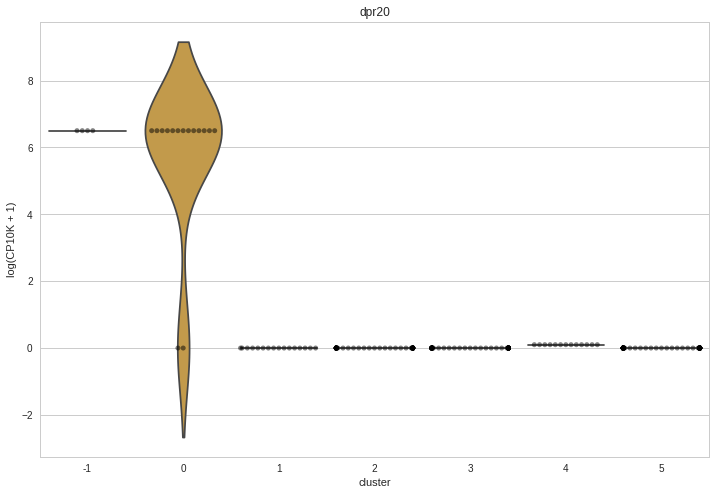

In [21]:
for gene in geneList:
    temp = pd.DataFrame({gene:dge[gene].tolist(),'cluster':clusterer.labels_},index=dge.index)
    fig, ax = plt.subplots(figsize=(12,8))
    sns.violinplot(x="cluster", y=gene, data=temp, inner=None)
    sns.swarmplot(x="cluster", y=gene, data=temp, color="k", alpha=.5);
    ax.set_ylabel('log(CP10K + 1)')
    ax.set_title(gene)
    #plt.savefig(gene + 'ExpressionViolins.jpg',format = 'jpg',dpi = 400)

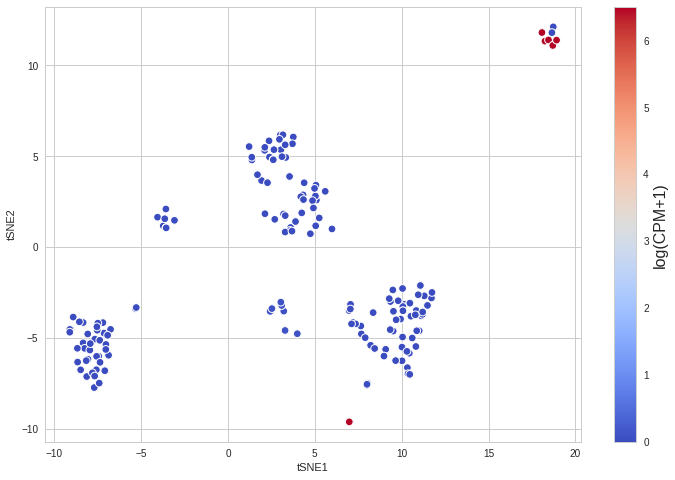

In [22]:
#FEATUR#FEATURE PLOTS (GENES)
fig, ax = plt.subplots(figsize=(12,8))
temp = ax.scatter(tsne_smushed[0], tsne_smushed[1],s=60, edgecolor='white', linewidth=1, 
           cmap='coolwarm',c=dge[g])
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')
cb = plt.colorbar(temp)
cb.set_label('log(CPM+1)',fontsize=16)

In [23]:
#LOAD DGE
dgeRough = pd.read_csv('/home/dnunez/DATA2/56_erm/dgeOneEditMerged.txt.gz', delim_whitespace=True, index_col=0)
dgeRough = dgeRough.transpose()
print(dgeRough.shape)
dgeRough = dgeRough.rename(columns={np.nan : "nan"})
dgeRough = dgeRough.fillna(value=0)

(1536, 12568)


In [24]:
#LOG NORMALIZE DGE
dgeRoughLN = np.log(dgeRough.div(dgeRough.sum(axis=1), axis=0)*1e4+1)

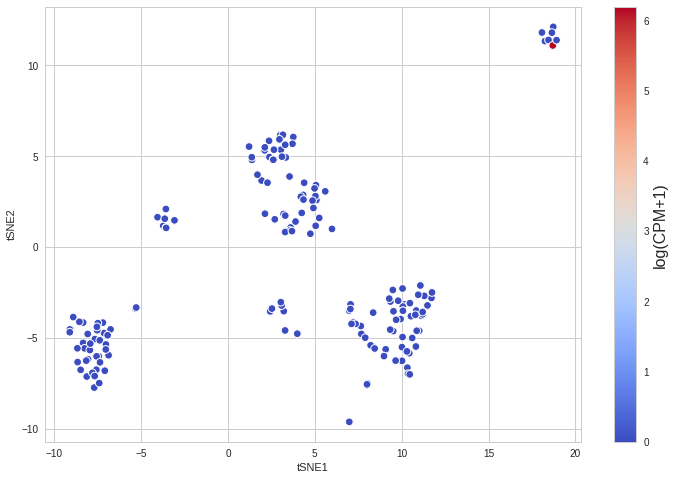

In [28]:
#FEATUR#FEATURE PLOTS (GENES) ... raw
fig, ax = plt.subplots(figsize=(12,8))
temp = ax.scatter(tsne_smushed[0], tsne_smushed[1],s=60, edgecolor='white', linewidth=1, 
           cmap='coolwarm',c=dgeRoughLN[g].loc[dge.index])
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')
cb = plt.colorbar(temp)
cb.set_label('log(CPM+1)',fontsize=16)
#ax.set_xlim([5,10])
#ax.set_ylim([-9.7,-9.5])

In [34]:
dgeRough[g].sort_values(ascending=False).head()

CCCCCTTAGACT    65
ATAGAAGTCTCT     1
TGGCTCCAAAAG     1
AACGTGGAATGA     1
CACCCGACTGCA     0
Name: dpr20, dtype: int64

In [37]:
tsne_smushed[dgeRough[g]>1]

/home/dnunez/DATA/Py3Env2/Py3Env2/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,0,1
CCCCCTTAGACT,18.70295,11.096601


In [35]:
dgeRough[g]>1

TATTGGTATGCG    False
TGATCGTCCGTA    False
TGTGCCCCAAGC    False
TTAAGCGCTTGC    False
TTAGCCGAGCAC    False
CCGGATGGCGAA    False
TGTCAATTACCA    False
CAGGTCAAATTC    False
TTGCTCGGGTTT    False
CATTTCGCGACA    False
CGACACAGCCTA    False
AAAGCTTCACAT    False
TCCCGATCGCCA    False
GACGTTGCGCGA    False
CCCGGTAAACGA    False
CGTTGTGCAAGT    False
CGCACCCCCAAA    False
AACATTTCATTG    False
GAGAAGTAAAAG    False
GTAAGGTAGTCG    False
TCGATTAGCTCT    False
TAGTTTCATGAG    False
GCGAAGTCGGCA    False
CCAGGGGTTGCA    False
TTTGTCAACTTC    False
CCGCTTAGATGC    False
CGTTGTTGCGGC    False
GTGAGCCAGGCG    False
CAGTTTGGTTGC    False
ATACAGCAGCGC    False
                ...  
ATTAATTACCGA    False
ATTCATCCATCA    False
ATTCCCATCAGT    False
ATTCCCTCAATC    False
ATTCGCAAATAN    False
ATTGCAACAGGN    False
ATTGCCGATTCT    False
ATTACTAATGTT    False
ATTGGGGGCGTN    False
ATTGGGGGGCGG    False
ATTGTCCAAGTT    False
ATTGTGTGCTGA    False
GTTTAGTTTCTA    False
ATTTCCACGGAT    False
ATTTCGCAGT

In [41]:
dgeSub = dge[clusterer.labels_==cluster]

In [42]:
varGenesSub = dgeSub.var().sort_values(ascending=False).iloc[0:1000].index
print('proportion mitochondrial: ' + str(len([s for s in varGenes if "mt:" in s[0:3]])/len(varGenes)))
print('proportion ribosomal protein: ' + str(len([s for s in varGenes if "Rp" in s[0:2]])/len(varGenes)))
print('proportion non-protein coding: ' + str(len([s for s in varGenes if "CR" in s[0:2]])/len(varGenes)))
print('proportion rRNA: ' + str(len([s for s in varGenes if "SrRNA" in s[1:7]])/len(varGenes)))
print('proportion tRNA: ' + str(len([s for s in varGenes if "tRNA:" in s[0:5]])/len(varGenes)))
print('proportion snRNA: ' + str(len([s for s in varGenes if "snRNA:" in s[0:6]])/len(varGenes)))
print('proportion snoRNA: ' + str(len([s for s in varGenes if "snoRNA:" in s[0:7]])/len(varGenes)))
print('proportion miRNA: ' + str(len([s for s in varGenes if "mir-" in s[0:4]])/len(varGenes)))
print('proportion lncRNA: ' + str(len([s for s in varGenes if "lncRNA:" in s[0:6]])/len(varGenes)))
print('proportion asRNA: ' + str(len([s for s in varGenes if "asRNA:" in s[0:5]])/len(varGenes)))
print('proportion pseudo: ' + str(len([s for s in varGenes if "-ps" in s])/len(varGenes)))

proportion mitochondrial: 0.009
proportion ribosomal protein: 0.085
proportion non-protein coding: 0.023
proportion rRNA: 0.003
proportion tRNA: 0.0
proportion snRNA: 0.0
proportion snoRNA: 0.005
proportion miRNA: 0.001
proportion lncRNA: 0.0
proportion asRNA: 0.0
proportion pseudo: 0.0


In [43]:
#Z-SCORE DATA
scaledDgeSub = (dgeSub - dgeSub.mean())/dgeSub.std()

(71, 5)
5


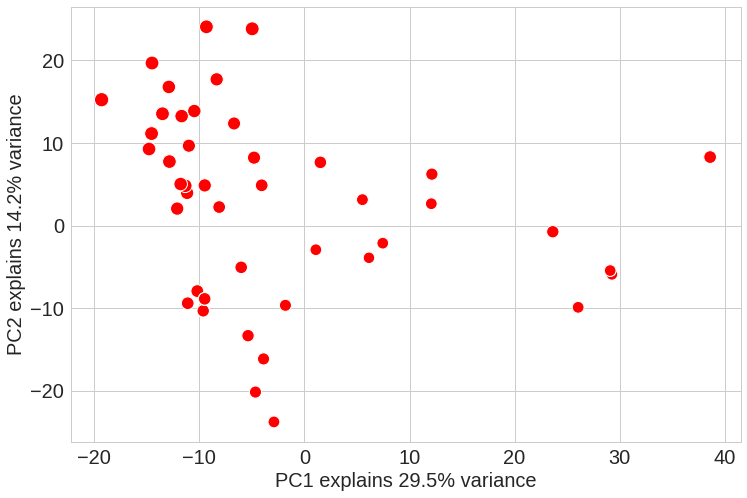

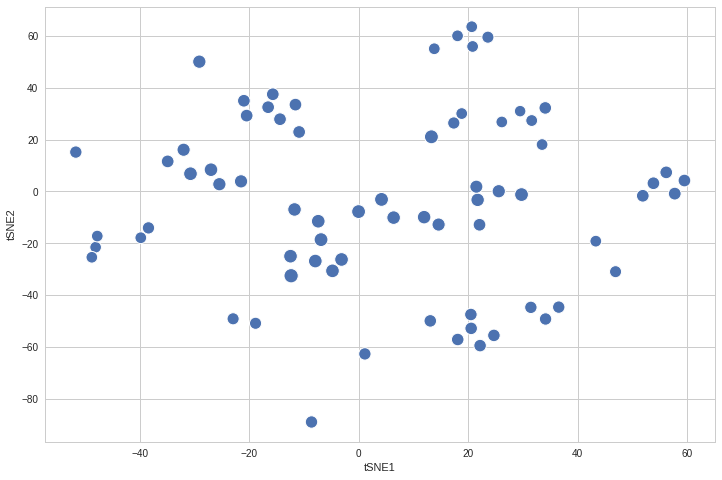

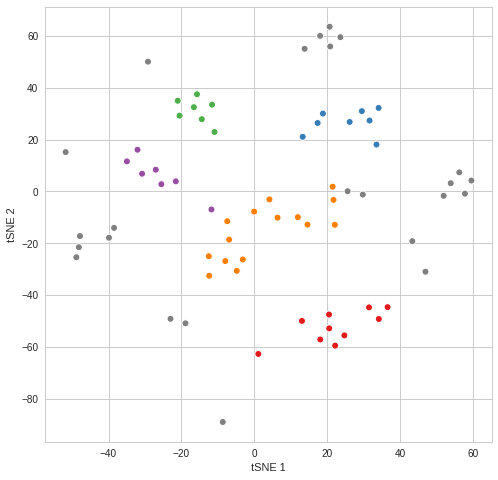

In [59]:
tsne_smushedSub, clustererSub = findClusters(scaledDgeSub,varGenesSub,5,5)

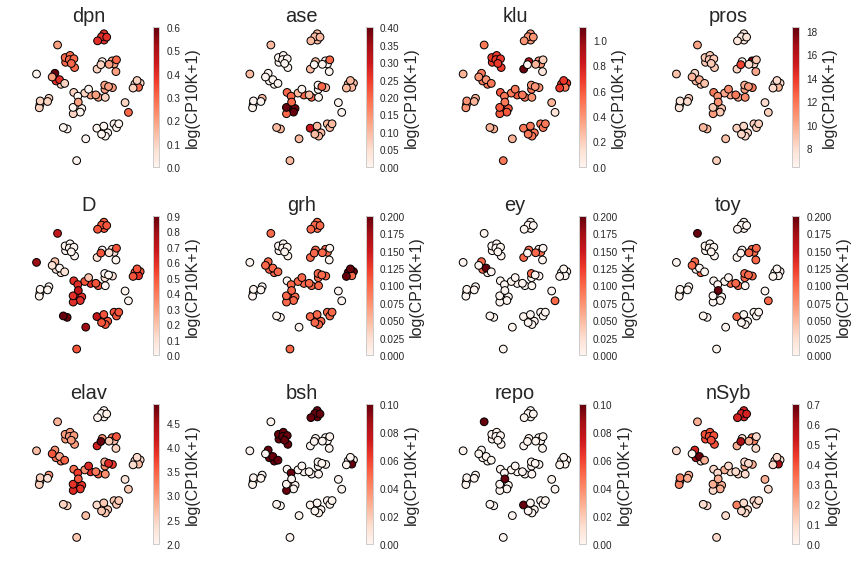

In [60]:
genes=['dpn','ase','klu','pros','D','grh','ey','toy','elav','bsh','repo','nSyb']
#plot genes of interest
fig, ax = plt.subplots(3,4, figsize=(12,8))
for i in range(0,4):
    scat = ax[0,i].scatter(tsne_smushedSub[0], tsne_smushedSub[1],s=60, edgecolor='black', linewidth=1, 
               cmap='Reds',c=dgeSub[genes[i]])
    cb = plt.colorbar(scat, ax=ax[0,i])
    cb.set_label('log(CP10K+1)',fontsize=16)
    ax[0,i].set_title(genes[i],fontsize=20)
    ax[0,i].grid(False)
    ax[0,i].set_axis_off()
for i in range(0,4):
    scat = ax[1,i].scatter(tsne_smushedSub[0], tsne_smushedSub[1],s=60, edgecolor='black', linewidth=1, 
               cmap='Reds',c=dgeSub[genes[4+i]])
    cb = plt.colorbar(scat,ax=ax[1,i])
    cb.set_label('log(CP10K+1)',fontsize=16)
    ax[1,i].set_title(genes[4+i],fontsize=20)
    ax[1,i].grid(False)
    ax[1,i].set_axis_off()
for i in range(0,4):
    scat = ax[2,i].scatter(tsne_smushedSub[0], tsne_smushedSub[1],s=60, edgecolor='black', linewidth=1, 
               cmap='Reds',c=dgeSub[genes[8+i]])
    cb = plt.colorbar(scat,ax=ax[2,i])
    cb.set_label('log(CP10K+1)',fontsize=16)
    ax[2,i].set_title(genes[8+i],fontsize=20)
    ax[2,i].grid(False)
    ax[2,i].set_axis_off()
fig.tight_layout()